# Delay embeddings for simple pendulum

In [1]:
import numpy as np
from numpy import random
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

(<matplotlib.legend.Legend at 0x1bd4b38b430>,
 <matplotlib.legend.Legend at 0x1bd200506d0>)

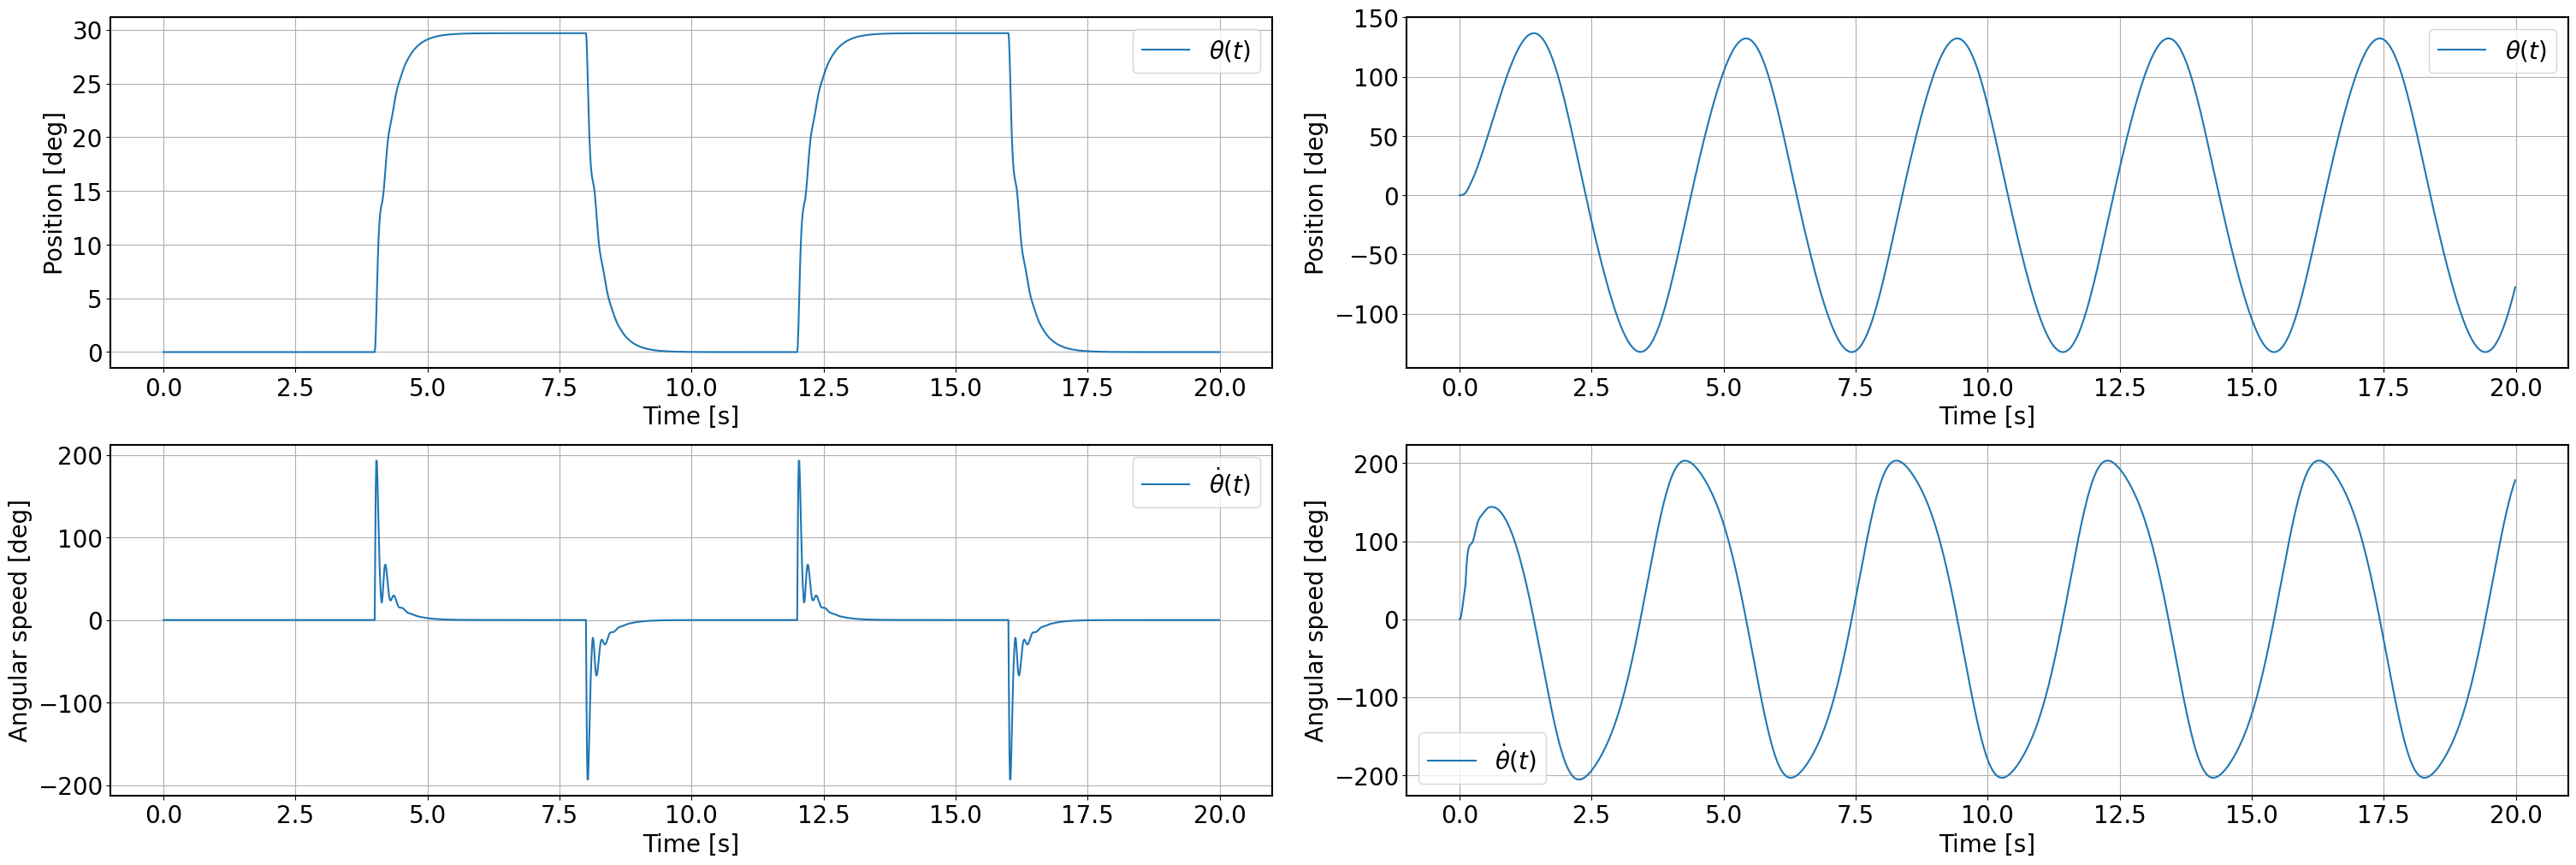

In [199]:
pend1, pend2 = SimplePendulum(mass=.7, length=.7), SimplePendulum(mass=.8, length=.8) # Create pendulum instance
pend1.dt, pend2.dt = 1e-2, 1e-2
pend1.T, pend1.X0, pend2.T, pend2.X0 = np.arange(0,20,pend1.dt), np.array([deg2rad(0),0]), np.arange(0,20,pend2.dt), np.array([deg2rad(0),0])
pend1.N, pend2.N = len(pend1.T), len(pend2.T)
K, Kd, Ki, t_max, K_sine = 40, 7, 60, 10, 18 # P(I)D controller parameters
f_ref = 0.25 # Reference frequency

# Reference and associated precision ratio (for LQR)
pend1.T_ref, pend2.T_ref = np.int(1/f_ref/pend1.dt), np.int(1/f_ref/pend2.dt)
pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(30),0], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend2.N, pend2.T_ref, [-deg2rad(150), deg2rad(150)])
pend1.U, pend2.U = np.zeros(shape=[pend1.N-1]), np.zeros(shape=[pend2.N-1])
pend1.X, pend2.X = np.empty(shape=[2,pend1.N]), np.empty(shape=[2,pend2.N])
pend1.X[:,0], pend2.X[:,0] = pend1.X0, pend2.X0
for i in range(pend1.N-1):
    if i == 0:
        pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X0, 0, pend1.dt, type='controller-step-by-step')
        pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X0, 0, pend2.dt, type='controller-step-by-step')
    else:
        pend1.U[i], pend2.U[i] = PID(pend1.X, i, pend1.ref[i], K, Kd, Ki, pend1.dt, t_max)[0], PID(pend2.X, i, pend2.ref[i], K_sine, Kd, Ki, pend2.dt, t_max)[0]
        pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
        pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')

# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(2, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

## Delay embeddings
The base regression problem writes under the form : <br><br>
$$\begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k) \Longrightarrow \begin{pmatrix} x_1(1) & x_2(1) \\ \vdots & \vdots \\ x_1(T) & x_2(T) \end{pmatrix} = \begin{pmatrix} x_1(0) & x_2(0) & u(0) \\ \vdots & \vdots & \vdots \\ x_1(T-1) & x_2(T-1) & u(T-1) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix} $$ <br><br>

However, this assumes that every single observation only linearly depends on the preceding one. This assumptions can be removed by setting a delay $\tau$ and now assuming that each state can be linearly expressed as a combination of the $\tau$ preceding states. In a Koopman framework, this can be thought as a state extension since the matrices $A$ and $B$ will both be extended too. Considering only one measurement at a time, this yields : <br><br>

$$ \begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} & A_{13} & \cdots & A_{(1,\tau/2-2)} & A_{(1,\tau/2-1)} \\ A_{21} & A_{22} & A_{23} & \cdots & A_{(2,\tau/2-1)} & A_{(2,\tau/2-1)} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \\ x_1(k-1) \\ x_2(k-1) \\ \vdots \\ x_1(k-\tau) \\ x_2(k-\tau) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k) $$<br><br>

This assumption was however not proposed for the input, for now (let's consider things separately at first). Of course, all of this will be set up by taking the whole simulation horizon into account for a more accurate result.<br><br>

$$ \begin{pmatrix} x_1(k+1) & x_2(k+1) \\ \vdots & \vdots \\ x_1(k+T) & x_2(k+T) \end{pmatrix} = \begin{pmatrix} x_1(k) & x_2(k) & x_1(k-1) & x_2(k-1) & \cdots & x_1(k-\tau) & x_2(k-\tau) & u(k) & \cdots & u(k-\tau) \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\ x_1(k+T-1) & x_2(k+T-1) & x_1(k+T-2) & x_2(k+T-2) & \cdots & x_1(k+T-1-\tau) & x_2(k+T-1-\tau) & u(T-1) & \cdots & u(T-1-\tau) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix} $$

Optimal truncation :  2


([<matplotlib.lines.Line2D at 0x1bd61adb370>],
 Text(0.5, 1.0, '$SVD \\ : \\ Y \\ \\frac{\\sigma_i}{\\sum \\sigma_j}$'))

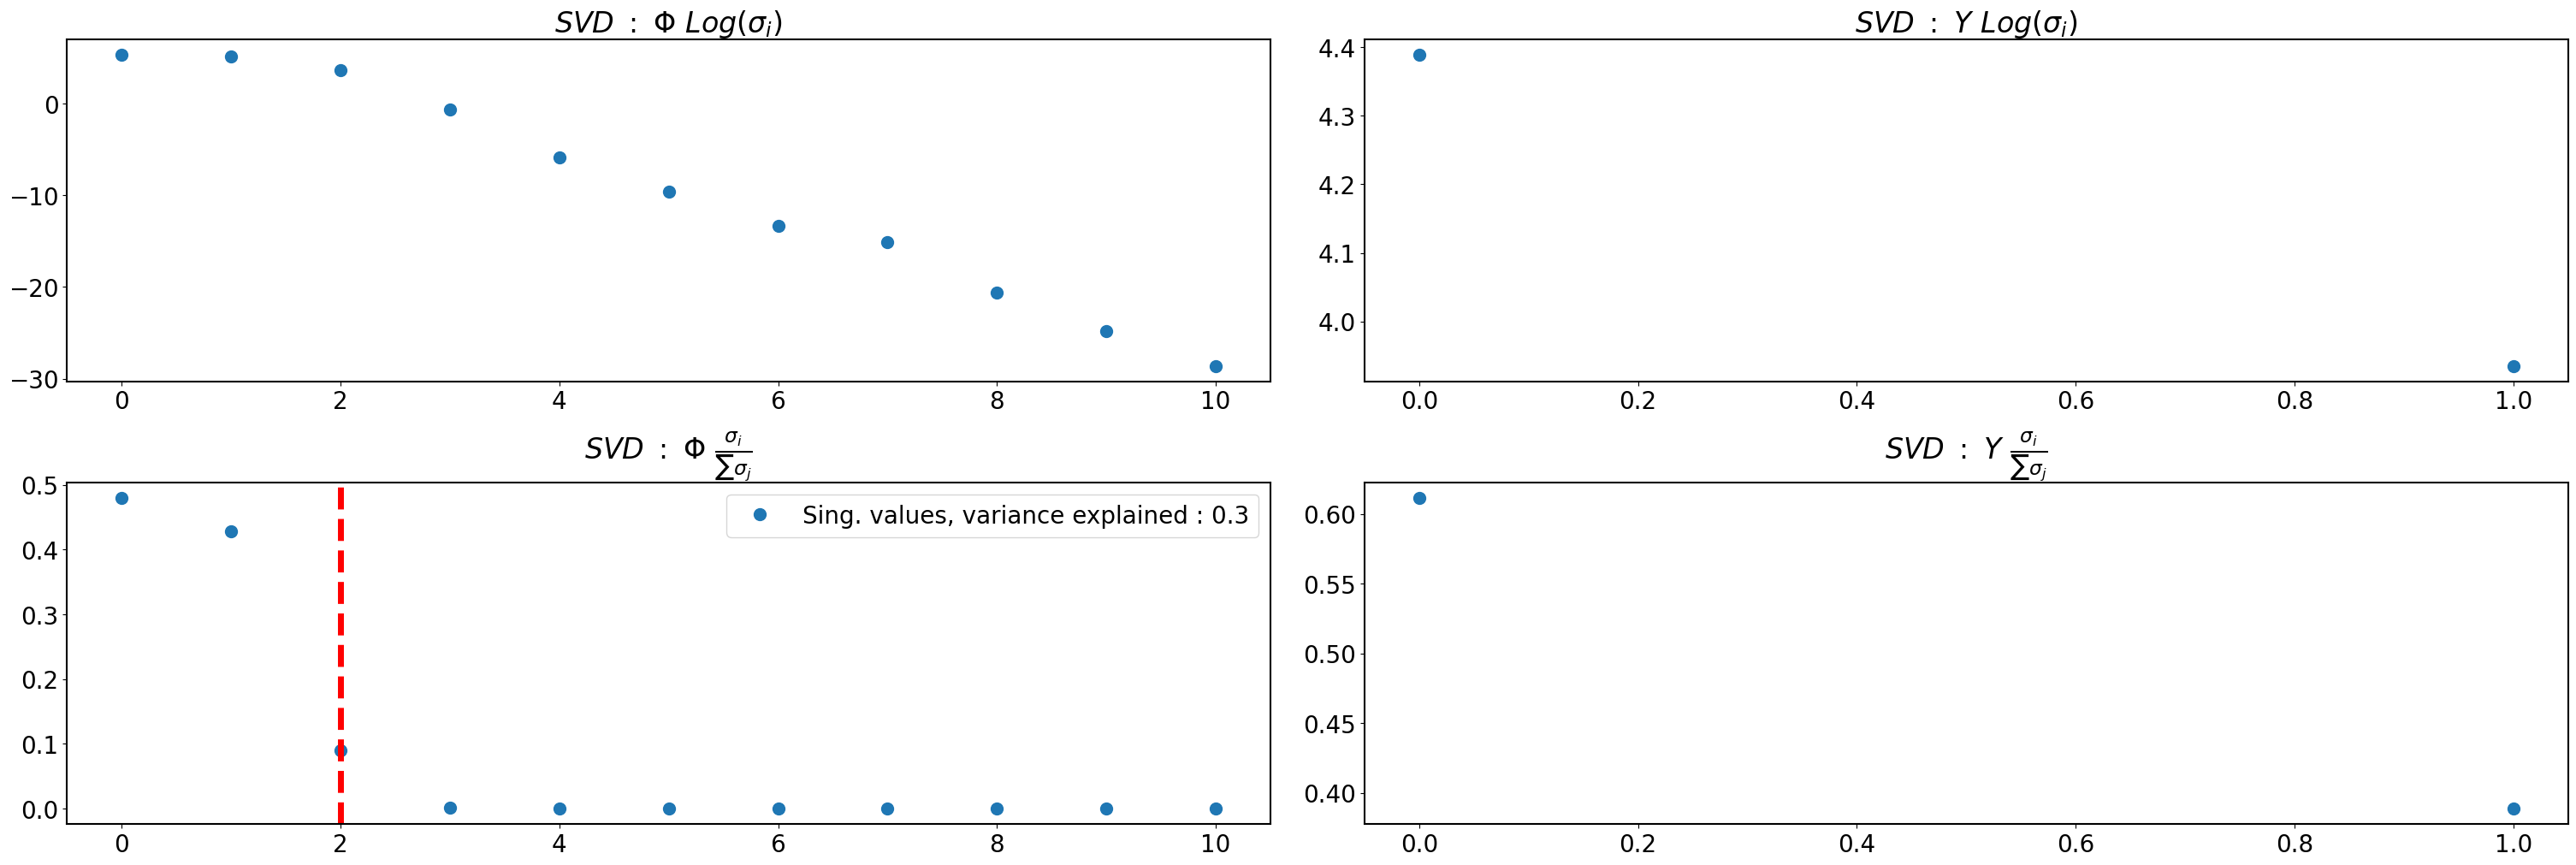

In [207]:
pend = pend2
horizon = np.int(len(pend.T)/2) # Trajectory planning horizon
tau = 5 # Maximum delay allowed

DLS1, explained_var = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1), .3
DLS1.SVD(truncation_ratio=explained_var)
print('Optimal truncation : ', DLS1.optimal_truncation)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(30,10))
ax[0,0].plot(np.log(DLS1.S), 'o', markersize=10), ax[0,0].set_title(r'$SVD \ : \ \Phi \ Log(\sigma_i)$')
ax[1,0].plot(DLS1.S/np.sum(DLS1.S), 'o', markersize=10, label='Sing. values, variance explained : '+str(explained_var)), ax[1,0].set_title(r'$SVD \ : \ \Phi \ \frac{\sigma_i}{\sum \sigma_j}$'), ax[1,0].legend()
ax[1,0].axvline(DLS1.optimal_truncation, linestyle='dashed', color='r', linewidth=5)
ax[0,1].plot(np.log(DLS1.S_y), 'o', markersize=10), ax[0,1].set_title(r'$SVD \ : \ Y \ Log(\sigma_i)$')
ax[1,1].plot(DLS1.S_y/np.sum(DLS1.S_y), 'o', markersize=10), ax[1,1].set_title(r'$SVD \ : \ Y \ \frac{\sigma_i}{\sum \sigma_j}$')

Y = 
 [[ 0.02232 -0.02955]
 [ 0.02217 -0.02936]
 [ 0.02203 -0.02916]
 ...
 [ 0.00161 -0.00213]
 [ 0.0016  -0.00212]
 [ 0.00159 -0.00211]] 
$\Phi$ = 
 [[ 0.02247 -0.02975  0.02262 ...  0.29096  0.03073  0.1605 ]
 [ 0.02232 -0.02955  0.02247 ...  0.29111  0.03053  0.15944]
 [ 0.02217 -0.02936  0.02232 ...  0.29126  0.03034  0.15839]
 ...
 [ 0.00162 -0.00215  0.00163 ...  0.31319  0.00246  0.01159]
 [ 0.00161 -0.00213  0.00162 ...  0.3132   0.00244  0.01151]
 [ 0.0016  -0.00212  0.00161 ...  0.31321  0.00243  0.01144]]
A = 
 [[-2.49264e+00  1.37317e-02 -5.55245e-01 ... -1.27971e-02 -2.44455e+00
  -6.11049e-03]
 [-1.10954e+03  3.77425e+00 -1.70026e+02 ... -6.65721e+00 -1.21627e+03
  -3.03979e+00]] 
B = 
 [[7.29207e-05]
 [2.91831e-02]]


## Low rank matrix using SVD truncation

In [59]:
DLS1.truncate(rank=2)
print(DLS1.A_p.shape, DLS1.B_p.shape)

(2, 100) (2,)


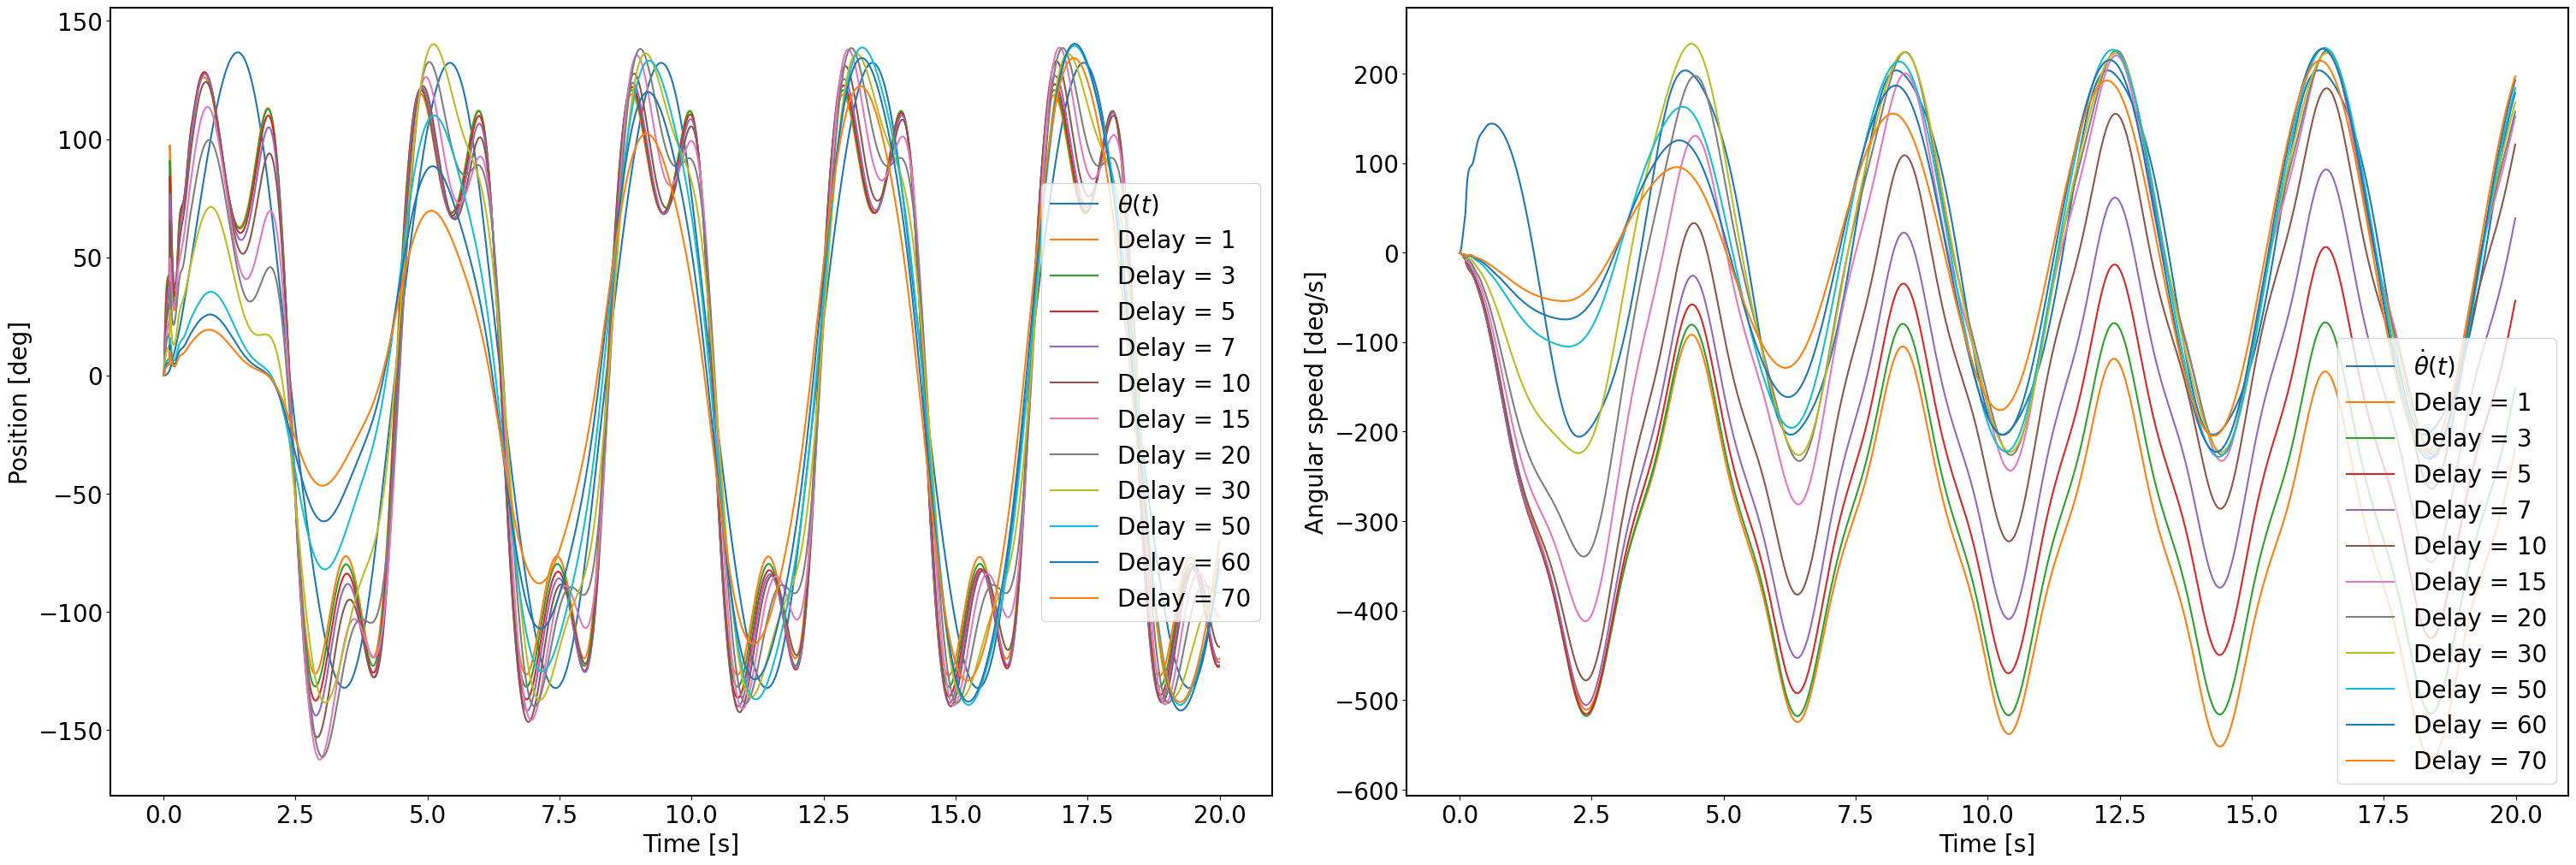

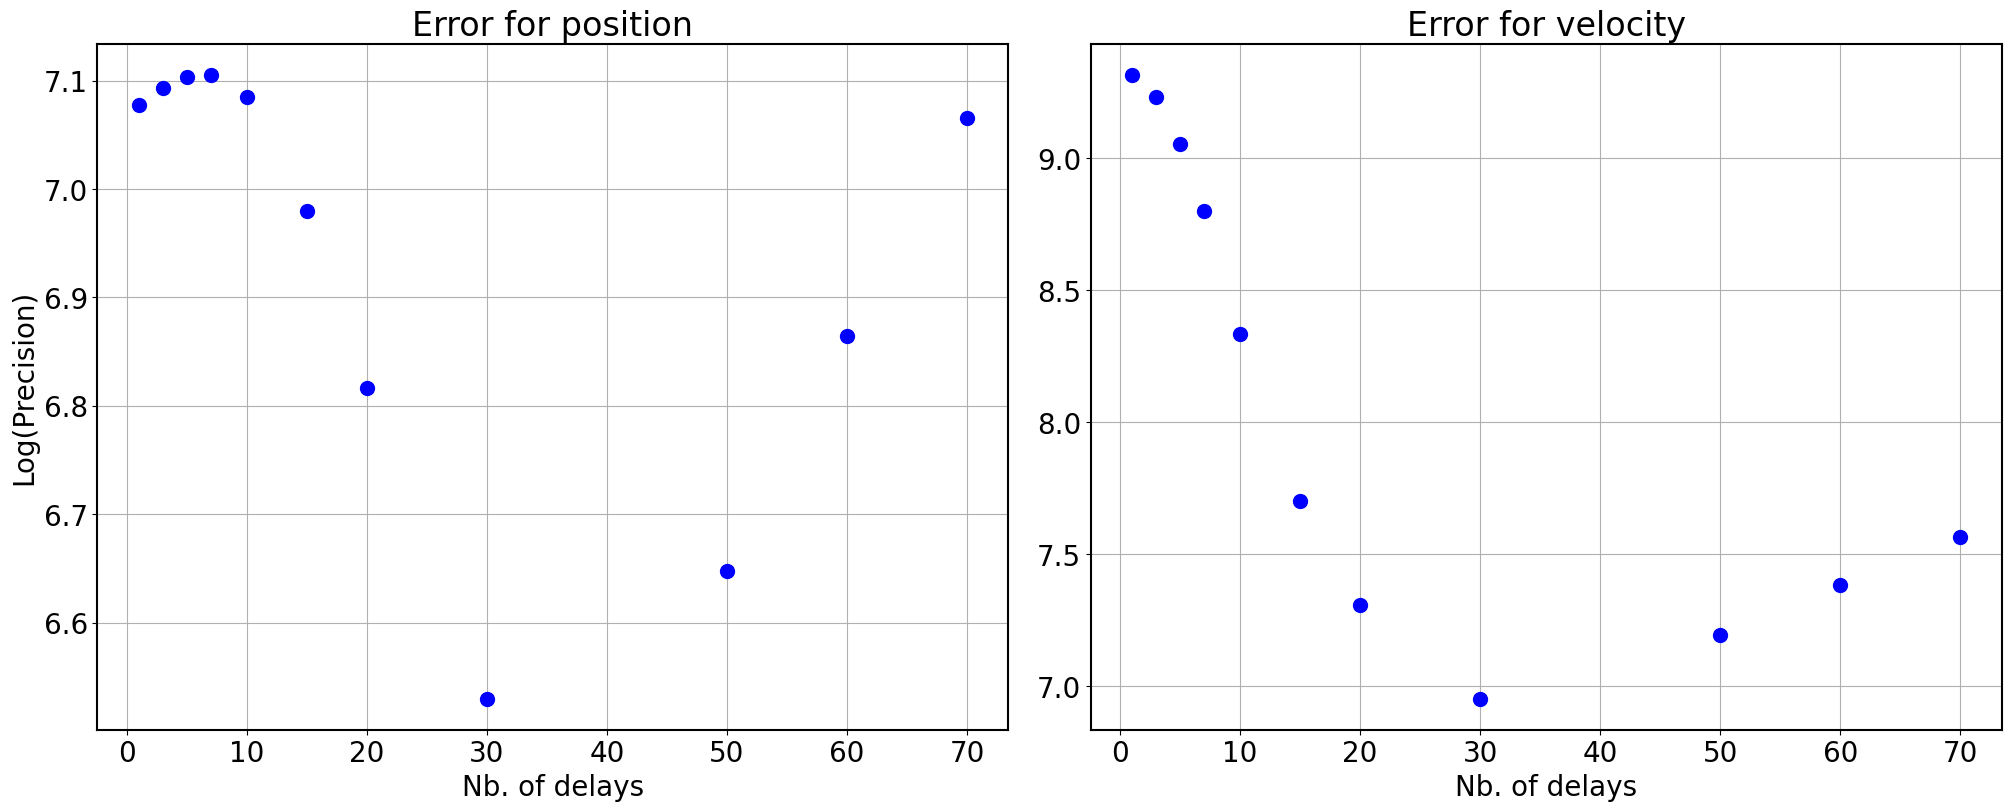

In [237]:
# Several plots
pend = pend2
# nb_delay = [1,10,20,30,40,50,100,150,180,200,250,300,400,500]
nb_delay = [1,3,5,7,10,15,20,30,50,60,70]
nb_plots = len(nb_delay)
horizon = np.int(pend.N/4)
explained_var = .01

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(30,10))
fig2, ax2 = plt.subplots(1, 2, constrained_layout = True, figsize=(20,8))
ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()
for i in range(nb_plots):
    tau = nb_delay[i]
    DLS1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
    DLS1.SVD(truncation_ratio=explained_var)
#     DLS1.truncate(rank=0)
    DLS1.truncate(rank=DLS1.optimal_truncation)
    DLS1.computeTrajectory(pend.X0, pend.U)
    DLS1.computePrecision(pend.X)
    
    ax[0].plot(pend.T[:len(pend.T)], rad2deg(DLS1.Traj[0,:]), label='Delay = '+str(tau))
    ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(pend.T[:len(pend.T)], rad2deg(DLS1.Traj[1,:]), label='Delay = '+str(tau))
    ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
    ax[1].grid()
    ax[1].legend()
    
    ax2[0].plot(tau, np.log(DLS1.precision[0]),'-o', markersize=10, color='b'), ax2[0].set_title('Error for position'), ax2[0].set_xlabel('Nb. of delays'), ax2[0].set_ylabel('Log(Precision)')
    ax2[1].plot(tau, np.log(DLS1.precision[1]),'-o', markersize=10, color='b'), ax2[1].set_title('Error for velocity'), ax2[1].set_xlabel('Nb. of delays')
    ax2[0].grid(), ax2[1].grid()

# LQR simulation with embedded delays <br>
First, choose the right delay embedding and train it.

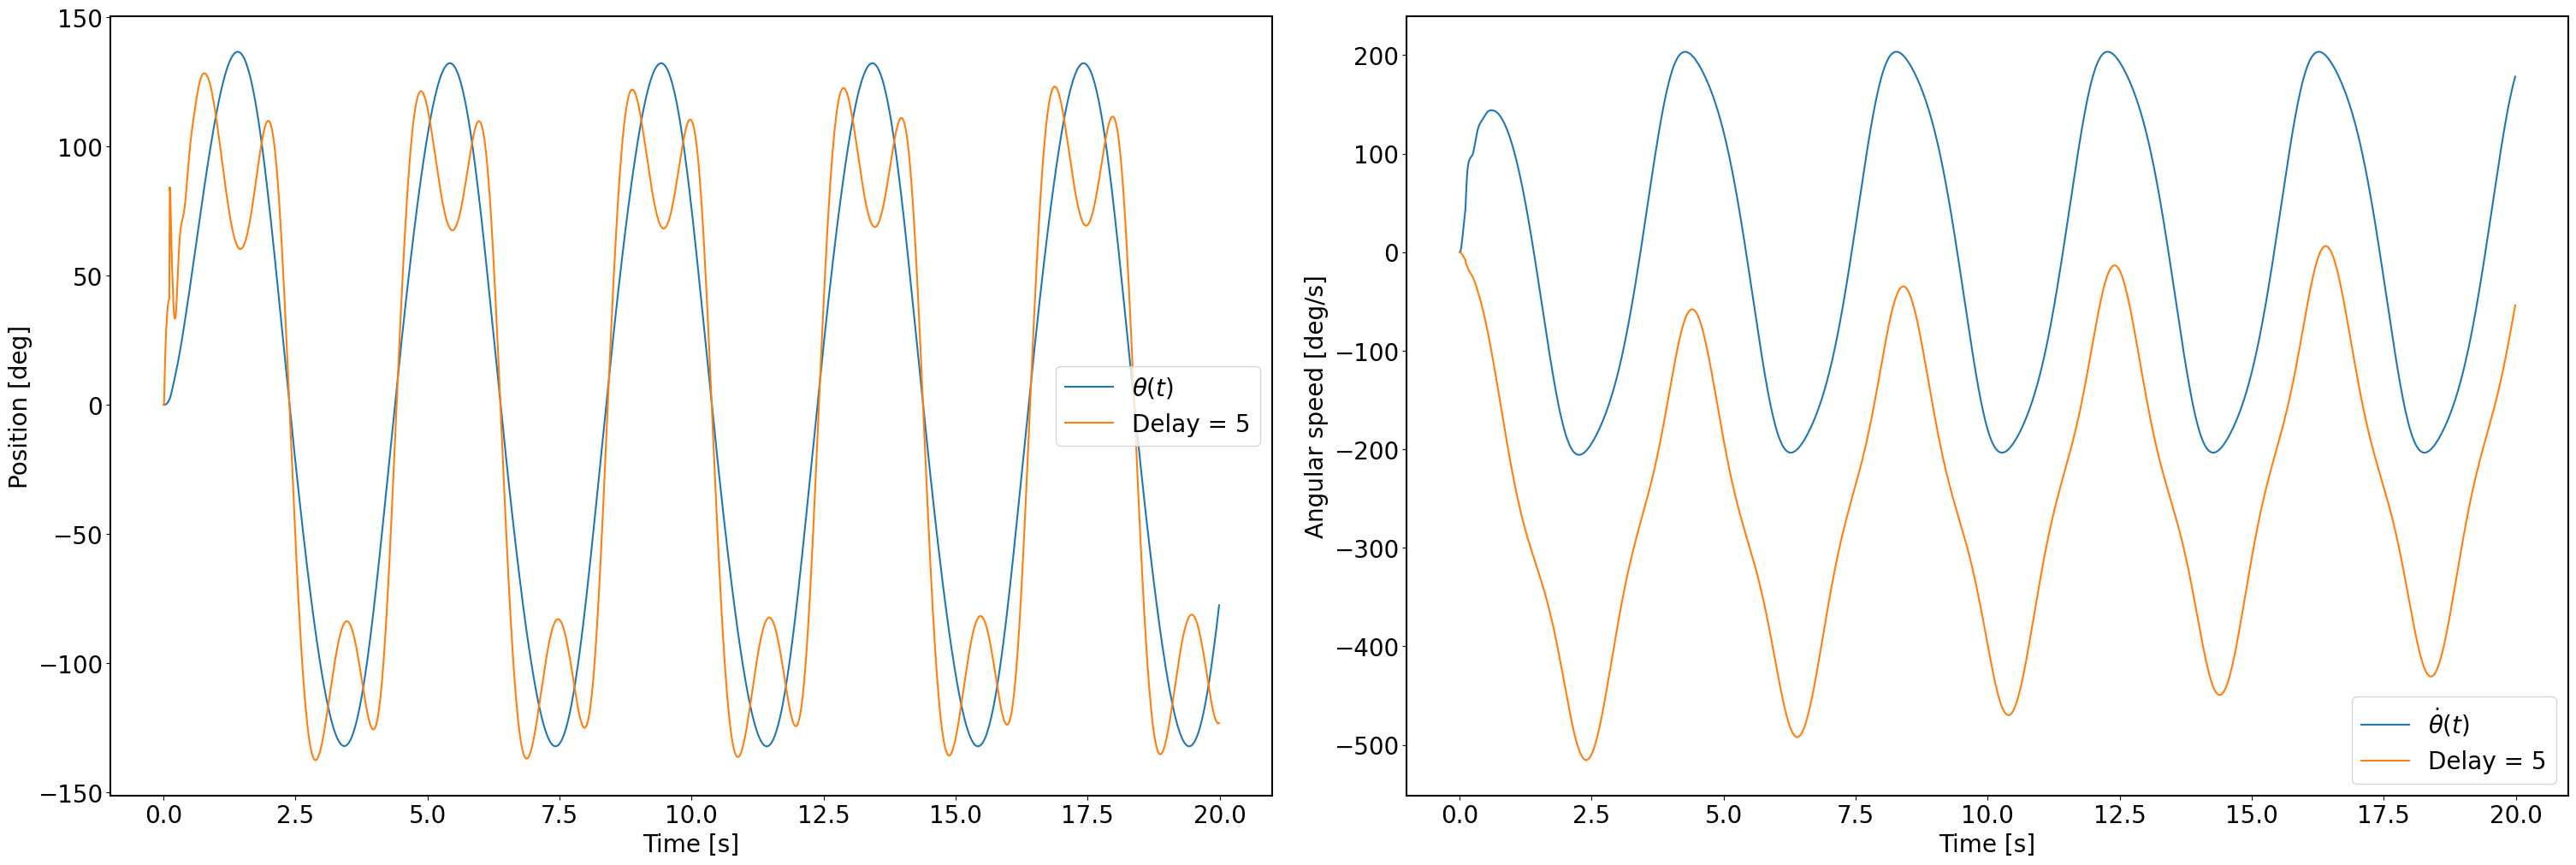

In [263]:
tau = 5
DLS1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
DLS1.SVD(truncation_ratio=.2)
DLS1.truncate(rank=DLS1.optimal_truncation)
# DLS1.truncate(rank=30)
DLS1.computeTrajectory(pend.X0, pend.U)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(30,10))

ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

ax[0].plot(pend.T[:len(pend.T)], rad2deg(DLS1.Traj[0,:]), label='Delay = '+str(tau))
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T[:len(pend.T)], rad2deg(DLS1.Traj[1,:]), label='Delay = '+str(tau))
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()

In [264]:
A_LQR = np.zeros(shape=[2*tau,2*tau])
A_LQR[0:2,:], A_LQR[2:2*tau,0:2*tau-2] = DLS1.A, np.eye(2*tau-2)
B_LQR = np.zeros(shape=[2*tau])
B_LQR[0:2] = DLS1.B[0]
B_LQR = B_LQR[:,np.newaxis]
lqr_tracking = pbd.LQR(A_LQR, B_LQR, nb_dim=A_LQR.shape[0], dt=pend1.dt, horizon=pend1.N)

# Trajectory for tracking
tracking_traj = np.zeros(shape=[pend1.N,2*tau]) # Vector for storing the trajectory
tracking_traj[:,0] = pend.ref
lqr_tracking.z = tracking_traj

# Trajectory timing (1 via-point = 1 time-step, should be as long as the horizon)
seq_tracking = 1*[0]

for i in range(1,pend1.N):
    seq_tracking += (1)*[i]
    
lqr_tracking.seq_xi = seq_tracking

# Control precision 
u_std = -2. # means 1e-3
lqr_tracking.gmm_u = u_std

# Tracking precision
x_std = 1e6 # Importance of tracking the position
Q_tracking = np.zeros(shape=[pend1.N,2*tau,2*tau])

for i in range(pend1.N):
    Q_tracking[i,0:2,0:2] = np.diag([x_std*precision[i],0*x_std]) # Put zero velocity precision
    
lqr_tracking.Q = Q_tracking
print(Q_tracking.shape)

lqr_tracking.ricatti()

(2000, 10, 10)


[ 0.       0.29311  0.31245 ... -0.12332 -0.08223 -0.04112]


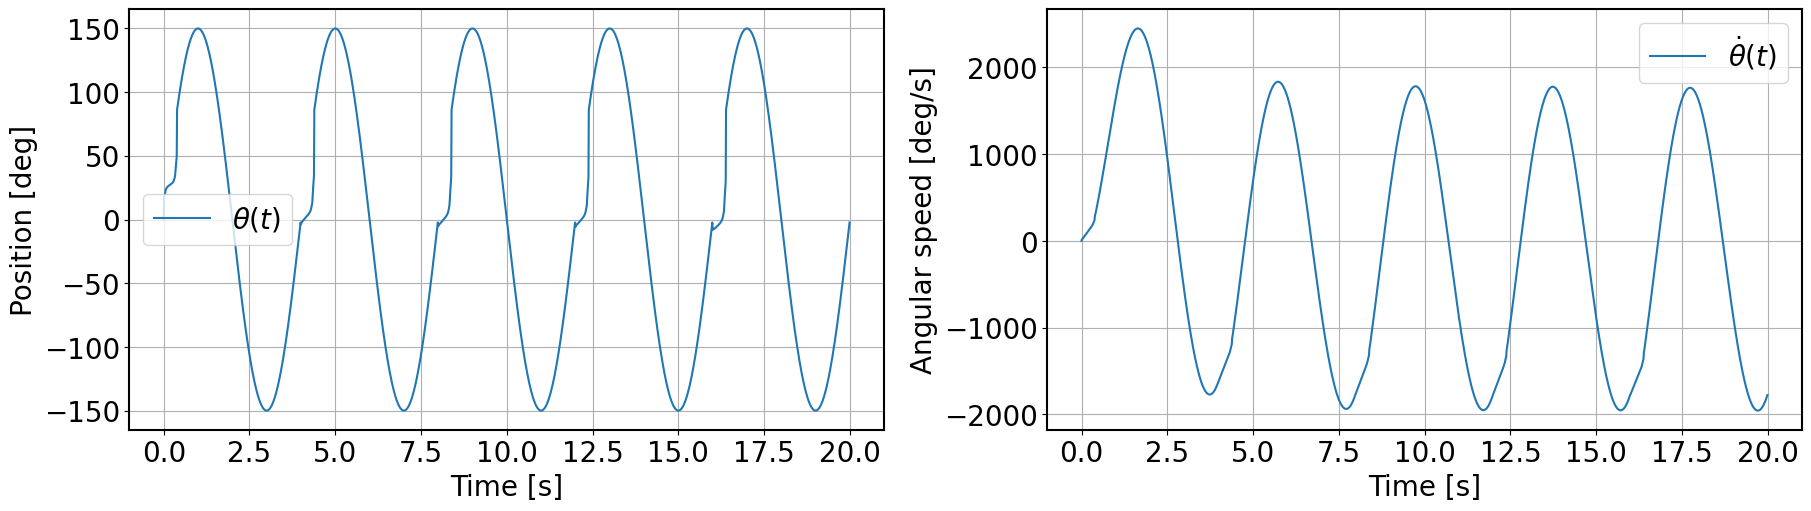

In [265]:
# Simulate the closed-loop system
X0 = np.zeros((10,2*tau))
xs, us = lqr_tracking.make_rollout(X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,5))
xs_mean = np.mean(xs, axis=0)
xs_std  = np.std(xs, axis=0)

ax[0].plot(pend1.T, rad2deg(xs_mean[:,0]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend1.T, rad2deg(xs_mean[:,1]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()
print(xs_mean[:,0])

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


[0.00027 0.05465 0.      0.      0.      0.      0.      0.      0.
 0.     ]
[0.00109 0.10925 0.00027 0.05465 0.      0.      0.      0.      0.
 0.     ]
[0.00246 0.16363 0.00109 0.10925 0.00027 0.05465 0.      0.      0.
 0.     ]
[0.00436 0.2176  0.00246 0.16363 0.00109 0.10925 0.00027 0.05465 0.
 0.     ]
[0.00681 0.27099 0.00436 0.2176  0.00246 0.16363 0.00109 0.10925 0.00027
 0.05465]


C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  output[0:2] = np.array((dx1dt,dx2dt))


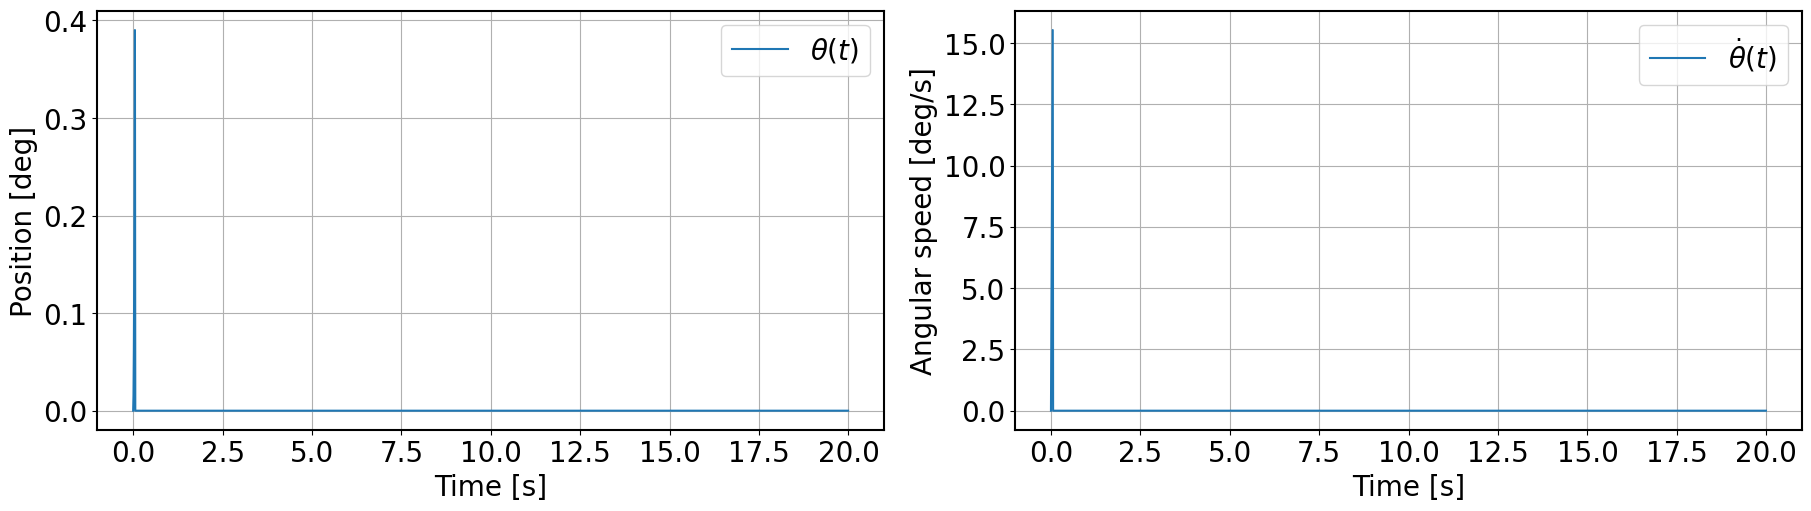

In [266]:
X0 = np.zeros(shape=[2*tau]) # Initial condition : [position [rad], velocity [rad/s]]
t_interval = pend.dt # Time-interval for one step to occur
Xc = np.zeros(shape=[pend.N,2*tau]) # Controlled trajectory
Uc = np.zeros(shape=[pend.N-1]) # Control input history
X_tau = np.zeros(shape=[2*tau]) # Vector for storing all x's past delays
Xc[0,:], X_tau = X0, X0
f = lambda theta, u : pend.dynamicsDelayed(theta, u, tau)
# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(5):
    
    u = lqr_tracking.get_command(X_tau, i) # Retrieve LQR control input
    Uc[i] = u
    # Next point of the non-linear controlled trajectory
    Xc[i+1,:] = RK4(f, Xc[i,:], [u], t_interval, type='controller-step-by-step').T
    # Shift elements in delays vector
    X_tau = np.roll(X_tau,2)
    X_tau[0:2] = Xc[i+1,0:2]
    print(X_tau)
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(18,5))

ax[0].plot(pend.T, rad2deg(Xc[:,0]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(Xc[:,1]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()

### Simulation in MPC fashion (solve DARE at each time-step)

In [ ]:
X0 = np.zeros(shape=[2*tau]) # Initial condition : [position [rad], velocity [rad/s]]
t_interval = pend.dt # Time-interval for one step to occur
Xc = np.zeros(shape=[pend.N,2*tau]) # Controlled trajectory
Uc = np.zeros(shape=[pend.N-1]) # Control input history
Xc[0,:] = X0
print(lqr_tracking.get_command(Xc[0,:], 0).shape)
f = lambda theta, u : pend.dynamicsDelayed(theta, u, tau)
# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend.N-1):
    
    u = lqr_tracking.get_command(Xc[i,:], i) # Retrieve LQR control input
    Uc[i] = u
    # Next point of the non-linear controlled trajectory
    Xc[i+1,:] = RK4(f, Xc[i,:], [u], t_interval, type='controller-step-by-step').T
    
# Plot
fig,ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(18,5))

ax[0].plot(pend.T, rad2deg(Xc[:,0]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(Xc[:,1]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()